**Brief Description**


This project leverages deep learning techniques to classify lung CT images into four categories: COVID-19 positive, Normal, Non-COVID Lung Opacity, and Viral Pneumonia. The primary objective is to assist physicians by providing an automated, accurate, and efficient diagnostic tool for detecting lung inflammations. The dataset consists of 21,165 images sourced from Kaggle, preprocessed to a fixed size of 256x256 pixels and normalized for uniformity. Pre-trained deep learning models, including ResNet50 and EfficientNet B0, were utilized, with customized classifiers and early stopping mechanisms ensuring optimal performance. This work showcases the potential of deep learning in medical diagnostics.

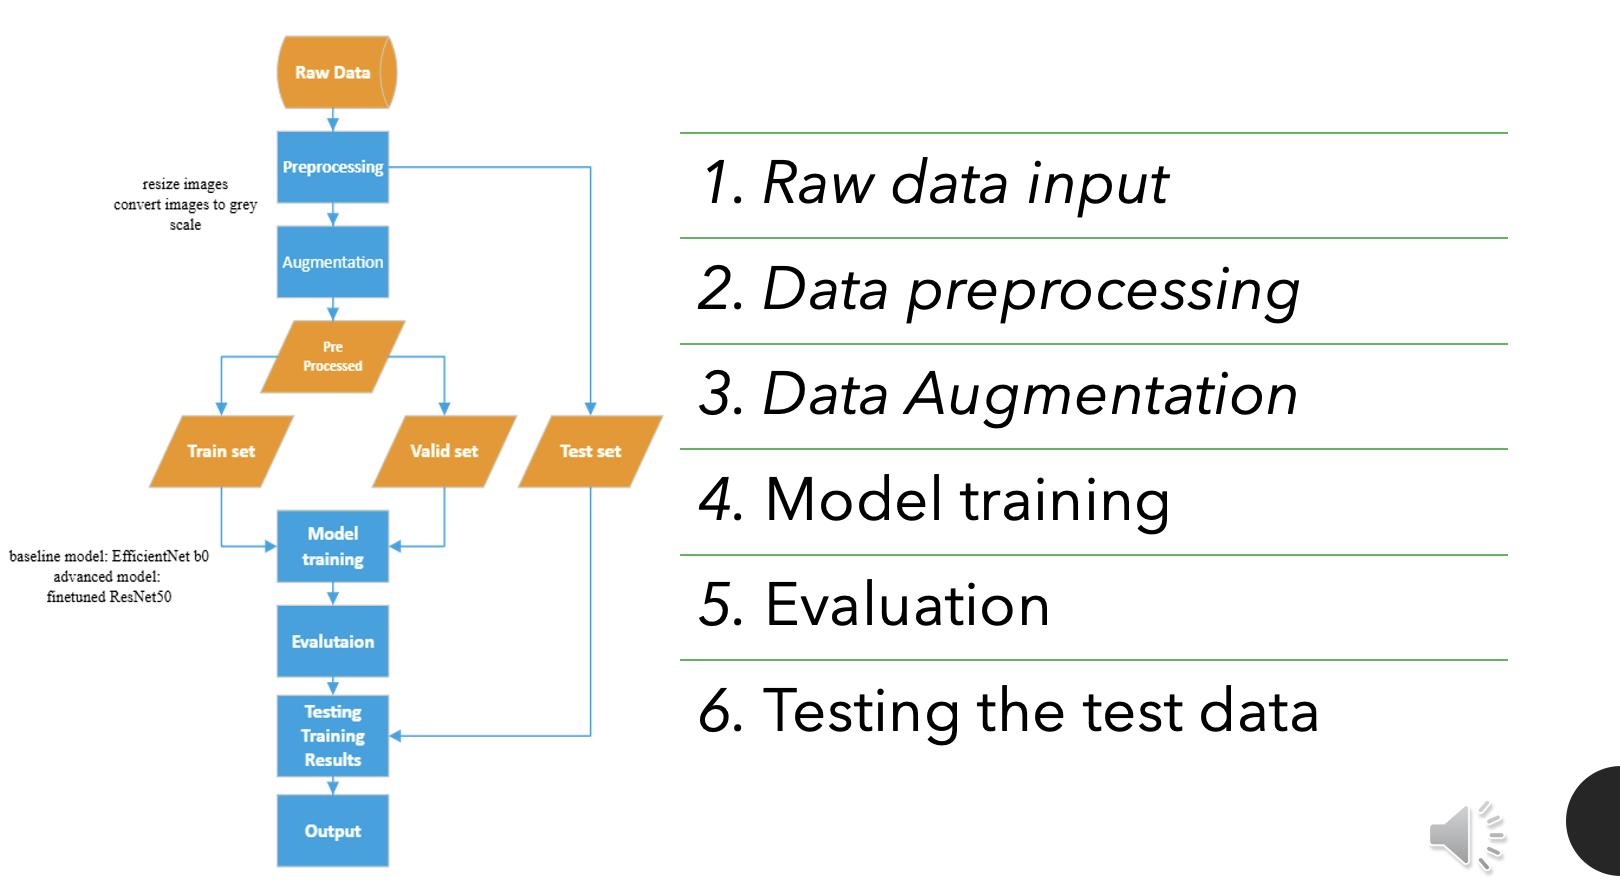

In [ ]:
pip install pillow


In [5]:
# pakages to use
import os
import random
import zipfile
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import shutil
from google.colab import files

In [ ]:
# TO BE COMPLETED
import zipfile

from google.colab import drive
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/lung_ct.zip'
zip_target = '/content'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(zip_target)

Mounted at /content/drive


In [ ]:
import os
from PIL import Image

extract_folder = '/content/lung_ct'

target_size = (256, 256)

def convert_and_resize_images(folder, target_size):
    for subdir, _, files in os.walk(folder):
        for file_name in files:
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(subdir, file_name)

                try:
                    with Image.open(file_path) as img:
                        if img.mode != 'L':
                            img = img.convert('L')
                        img = img.resize(target_size, Image.LANCZOS)
                        img.save(file_path)
                        print(f"Converted and resized {file_path} to {target_size}.")
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

convert_and_resize_images(extract_folder, target_size)


Streaming output truncated to the last 5000 lines.
Converted and resized /content/lung_ct/Lung_Opacity/Lung_Opacity-4636.png to (256, 256).
Converted and resized /content/lung_ct/Lung_Opacity/Lung_Opacity-998.png to (256, 256).
Converted and resized /content/lung_ct/Lung_Opacity/Lung_Opacity-2893.png to (256, 256).
Converted and resized /content/lung_ct/Lung_Opacity/816.jpg to (256, 256).
Converted and resized /content/lung_ct/Lung_Opacity/Lung_Opacity-4353.png to (256, 256).
Converted and resized /content/lung_ct/Lung_Opacity/455.jpg to (256, 256).
Converted and resized /content/lung_ct/Lung_Opacity/Lung_Opacity-91.png to (256, 256).
Converted and resized /content/lung_ct/Lung_Opacity/625.jpg to (256, 256).
Converted and resized /content/lung_ct/Lung_Opacity/Lung_Opacity-4971.png to (256, 256).
Converted and resized /content/lung_ct/Lung_Opacity/Lung_Opacity-5538.png to (256, 256).
Converted and resized /content/lung_ct/Lung_Opacity/Lung_Opacity-2535.png to (256, 256).
Converted and r

In [ ]:
import shutil

shutil.make_archive('/content/lung_ct_resized', 'zip', '/content/lung_ct')


'/content/lung_ct_resized.zip'

In [ ]:
from google.colab import files
files.download('/content/lung_ct_resized.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
'''
We have already resize the iamges as 256X256, and comvert the RGB images\
to grey. Now We upload these preprocessed images again and start resolve\
the data imbalance problem.
'''

In [ ]:
'''
Now we have 12854 normal lung images, 7137 lung opacity images, 3957\
viral pneumonia images, 2727 bacterial pneumonia images, and 4596 covid\
images. Given this distribution, the dataset is imbalanced, with many \
more normal lung images than other categories. Here we can use some method\
to deal with the imbalanced dataset. We can use data augmentation to\
increase the diversity of the minority classes such as bacterial pneumonia,\
viral pneumonia, and COVID)
'''

In [28]:
import os
import zipfile
from PIL import Image
import torchvision.transforms as transforms
import random

# Define paths
zip_file_path = '/content/lung_ct_resized-2.zip'
extract_dir = '/content/lung_ct_resized-2'
augmented_dir = '/content/lung_ct_augmented'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Count images in each class
class_counts = {}
for class_folder in os.listdir(extract_dir):
    class_path = os.path.join(extract_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_folder] = num_images

# Find the maximum class count
target_count = max(class_counts.values())

# data augmentations
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])

# Apply augmentation for minority classes
for class_folder, count in class_counts.items():
    class_path = os.path.join(extract_dir, class_folder)
    augmented_class_path = os.path.join(augmented_dir, class_folder)
    os.makedirs(augmented_class_path, exist_ok=True)

    # Copy existing images to augmented folder
    for img_name in os.listdir(class_path):
        img = Image.open(os.path.join(class_path, img_name))
        img.save(os.path.join(augmented_class_path, img_name))

    # check
    if count < target_count:
        images = os.listdir(class_path)
        for i in range(target_count - count):
            img_name = random.choice(images)
            img = Image.open(os.path.join(class_path, img_name)).convert("L")  # Convert to grayscale
            augmented_img = augmentation_transforms(img)
            augmented_img.save(os.path.join(augmented_class_path, f"{img_name.split('.')[0]}_aug_{i}.png"))

print(f"Balanced dataset saved in {augmented_dir}")




Balanced dataset saved in /content/lung_ct_augmented


In [29]:
class_counts = {}

for class_folder in os.listdir('/content/lung_ct_augmented'):
  class_path = os.path.join('/content/lung_ct_augmented', class_folder)
  if os.path.isdir(class_path):
    # Count the number of images
    num_images = len([file for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file))])
    class_counts[class_folder] = num_images

for class_name, count in class_counts.items():
  print(f"Class '{class_name}' has {count} images")

Class 'Normal' has 12854 images
Class 'Lung_Opacity' has 12854 images
Class 'viral_pneumonia 2' has 12854 images
Class 'covid 2' has 12854 images
Class 'bacterial_pneumonia' has 12854 images


In [ ]:
'''
Now the dataset is balanced and ready for training.
'''

In [30]:
# Zip the augmented folder for download
!zip -r /content/lung_ct_augmented.zip /content/lung_ct_augmented

流式输出内容被截断，只能显示最后 5000 行内容。
  adding: content/lung_ct_augmented/bacterial_pneumonia/person1493_bacteria_3896_aug_4760.png (stored 0%)
  adding: content/lung_ct_augmented/bacterial_pneumonia/50 (2)_aug_1258.png (stored 0%)
  adding: content/lung_ct_augmented/bacterial_pneumonia/person119_bacteria_565.jpeg (stored 0%)
  adding: content/lung_ct_augmented/bacterial_pneumonia/person653_bacteria_2545.jpeg (stored 0%)
  adding: content/lung_ct_augmented/bacterial_pneumonia/person558_bacteria_2328.jpeg (stored 0%)
  adding: content/lung_ct_augmented/bacterial_pneumonia/person997_bacteria_2926_aug_3183.png (stored 0%)
  adding: content/lung_ct_augmented/bacterial_pneumonia/person26_bacteria_132_aug_8168.png (stored 0%)
  adding: content/lung_ct_augmented/bacterial_pneumonia/person1413_bacteria_3617.jpeg (stored 0%)
  adding: content/lung_ct_augmented/bacterial_pneumonia/552_aug_6267.png (stored 0%)
  adding: content/lung_ct_augmented/bacterial_pneumonia/person26_bacteria_131.jpeg (stored 0%)
  a

In [ ]:
import os
import shutil
import random
from pathlib import Path

# Set the paths
root_dir = 'C:/uoft/1517/content/content/lung_ct_augmented'  # Replace with the path to your root directory
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
test_dir = os.path.join(root_dir, 'test')

# Create the target directories
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Parameters for splitting
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Check that splits add up to 1
assert train_split + val_split + test_split == 1, "Splits do not add up to 1!"

# Function to split and copy images
def split_data(source, train_dir, val_dir, test_dir):
    for category in os.listdir(source):
        category_path = os.path.join(source, category)
        
        # Skip if not a directory
        if not os.path.isdir(category_path):
            continue
        
        # Get list of files
        files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
        random.shuffle(files)

        # Calculate split indices
        train_end = int(len(files) * train_split)
        val_end = train_end + int(len(files) * val_split)

        # Split files
        train_files = files[:train_end]
        val_files = files[train_end:val_end]
        test_files = files[val_end:]

        # Create category directories in train, val, test
        for folder, file_set in zip([train_dir, val_dir, test_dir], [train_files, val_files, test_files]):
            target_category_dir = os.path.join(folder, category)
            os.makedirs(target_category_dir, exist_ok=True)

            # Copy files
            for file in file_set:
                src = os.path.join(category_path, file)
                dst = os.path.join(target_category_dir, file)
                shutil.copy2(src, dst)

# Run the split
split_data(root_dir, train_dir, val_dir, test_dir)

In [ ]:
"""

The following directory structure is created after running the code:

- data
  - train
    - class1
    - class2
    - ...
  - val
    - class1
    - class2
    - ...
  - test
    - class1
    - class2
    - ...

The reason is to match the input format of the ImageFolder dataset class in PyTorch.

Next we will construct a custom dataset class to load the images from the directory structure we create

The following section is the data loading, model definition and helper functions we have created for the purpose of tranning the model
"""

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import copy

In [ ]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataloader
def get_data_loaders(train_dir, val_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    ])

    # the dataset consist of 5 classes with grey scale lung ct scan images
    # There are 12854 normal lung images, 7137 lung opacity images, 3957 viral pneumonia images, 2727 bacterial pneumonia images, and 4596 covid images
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# model
# baseline
class BaselineEfficientNet(nn.Module):
    def __init__(self, num_classes=6):
        super(BaselineEfficientNet, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False  # freeze
        num_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# class Model(nn.Module):
#     def __init__(self, num_classes=6):
#         super(Model, self).__init__()
#         self.feature_extractor = models.resnet50(pretrained=True)
#         self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-1])
#         self.classifier = models.efficientnet_b0(pretrained=True)
#         num_features = self.classifier.classifier[1].in_features
#         self.classifier.classifier = nn.Sequential(
#             nn.Dropout(p=0.4),
#             nn.Linear(num_features, num_classes)
#         )

#     def forward(self, x):
#         with torch.no_grad():
#             features = self.feature_extractor(x)
#             features = features.view(features.size(0), -1)
#             outputs = self.classifier(features)
#         return outputs

# for testing purpose we will use the pretrained resnet50 model to extract features and use the features to train the model
class Model(nn.Module):
    def __init__(self, num_classes=6):
        super(Model, self).__init__()
        
        # Use ResNet50 as feature extractor
        self.feature_extractor = models.resnet50(pretrained=True)

        # Remove the last fully connected layer and add a new classifier layer
        num_features = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        # Forward pass through ResNet
        return self.feature_extractor(x)

# train
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler, device, patience=5, warmup_steps=0):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.best_model_wts = copy.deepcopy(model.state_dict())
        self.best_accuracy = 0.0
        self.patience = patience
        self.warmup_steps = warmup_steps
        self.early_stop = False
        self.counter = 0
        self.best_score = None

    def train(self, num_epochs=10):
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0

            for step, (inputs, labels) in enumerate(self.train_loader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # warm-up steps
                if step < self.warmup_steps:
                    lr_scale = min(1.0, float(step + 1) / self.warmup_steps)
                    for pg in self.optimizer.param_groups:
                        pg['lr'] = lr_scale * self.optimizer.defaults['lr']

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                running_loss += loss.item()

            train_loss = running_loss / len(self.train_loader)
            val_loss, val_accuracy = self.validate()

            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

            # early stopping
            self._early_stopping(val_loss)
            if self.early_stop:
                print("Early stopping triggered")
                break

            if val_accuracy > self.best_accuracy:
                self.best_accuracy = val_accuracy
                self.best_model_wts = copy.deepcopy(self.model.state_dict())

        self.model.load_state_dict(self.best_model_wts)
        return self.model

    def validate(self):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        return val_loss / len(self.val_loader), accuracy

    def _early_stopping(self, val_loss):
        score = -val_loss
        if self.best_score is None or score > self.best_score:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
# setup
train_loader, val_loader = get_data_loaders('C:/uoft/1517/content/content/lung_ct_augmented/train', 'C:/uoft/1517/content/content/lung_ct_augmented/val')
model = Model(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-6)

# train model
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, scheduler, device, patience=5, warmup_steps=100)

#print out first five pictures of train_loader
trained_model = trainer.train(num_epochs=20)

# save model checkpoint
torch.save(trained_model.state_dict(), 'resnet_efficientnet_finetuned.pth')


# load model
trained_model.load_state_dict(torch.load('resnet_efficientnet_finetuned.pth'))
trained_model.eval()



Epoch 1/20, Train Loss: 0.2642, Val Loss: 0.1353, Val Accuracy: 95.18%
Epoch 2/20, Train Loss: 0.1209, Val Loss: 0.1133, Val Accuracy: 96.09%
Epoch 3/20, Train Loss: 0.0756, Val Loss: 0.1498, Val Accuracy: 94.96%
EarlyStopping counter: 1 out of 5
Epoch 4/20, Train Loss: 0.0517, Val Loss: 0.1267, Val Accuracy: 95.57%
EarlyStopping counter: 2 out of 5
Epoch 5/20, Train Loss: 0.0404, Val Loss: 0.1133, Val Accuracy: 96.41%
Epoch 6/20, Train Loss: 0.0327, Val Loss: 0.1082, Val Accuracy: 96.84%
Epoch 7/20, Train Loss: 0.0291, Val Loss: 0.1110, Val Accuracy: 96.66%
EarlyStopping counter: 1 out of 5
Epoch 8/20, Train Loss: 0.0236, Val Loss: 0.3039, Val Accuracy: 92.18%
EarlyStopping counter: 2 out of 5
Epoch 9/20, Train Loss: 0.0261, Val Loss: 0.1224, Val Accuracy: 96.83%
EarlyStopping counter: 3 out of 5
Epoch 10/20, Train Loss: 0.0223, Val Loss: 0.1078, Val Accuracy: 96.99%
Epoch 11/20, Train Loss: 0.0223, Val Loss: 0.1259, Val Accuracy: 96.47%
EarlyStopping counter: 1 out of 5
Epoch 12/20, 

C:\Users\93757\AppData\Local\Temp\ipykernel_29872\1336341897.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load('resnet_efficientn

Model(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [ ]:
"""
The above data is the training result

The model demonstrated strong training and validation performance over the 15 epochs, with the following key points:

    Training Loss: Decreased consistently from 0.2642 to 0.0157 shows effective learning and a reduction in errors over time.
    Validation Loss: Fluctuated, starting at 0.1353 and showing a notable increase in certain epochs, such as 0.3039 in epoch 8. However, it generally stabilized, with the lowest validation loss reaching 0.1078 in epoch 10.
    Validation Accuracy: Reached a high level, starting at 95.18% and peaking at 96.99% in epoch 10. This suggests good model generalization with strong classification performance on the validation set.


Overall, the model achieved high validation accuracy with a steady reduction in training loss.
The similary accuracy can be achieved by using the pretrained model indicates that the model has learned the features of the images well and can generalize to new data effectively.

"""

### Overview

This report summarizes the progress in training a model designed to classify five lung conditions: bacterial pneumonia, COVID-19, lung opacity, normal, and viral pneumonia from three different dataset. Image Augmentations and transformation were implemented before used for model training. The model was inherited from ResNet50 pretrained model and trained on grayscale Lung X-ray scan images. Early stopping was employed to optimize model generalization and prevent overfitting.

### Performance
1.	Training Loss: The model showed a consistent decrease in training loss from 0.2642 to 0.0157 shows effective learning across the dataset.
2.	Validation Loss: Although the validation loss fluctuated, reaching a low of 0.1078 at epoch 10, some increases were observed in later epochs. These fluctuations may suggest some degree of overfitting.
3.	Validation Accuracy: The model achieved high validation accuracy demonstrating strong classification performance across the five lung disease classes.

The Resnet50 pretrained model shows promising results with high accuracy and decreasing training loss. However, the fluctuations in validation loss indicate minor overfitting. Early stopping effectively prevented further overfitting, but additional regularization or data augmentation could further enhance model stability.

### Next Steps
1.	Hyperparameter Tuning: Adjust hyperparameters, focusing on regularization, to reduce overfitting.
2.	Data Augmentation: Increase dataset diversity using augmentation techniques to improve generalization across the five lung disease categories.
3.	Extended Testing: Conduct further testing on unseen data to confirm robustness and explore model assembling for potential performance gains.


In conclusion, the model has achieved strong preliminary results, with high validation accuracy and low training loss. Additional tuning and testing should enhance its classification performance for lung disease detection.
